# CS485: Data Science and Applications
## Assignment 6
### Vasileios Papageridis - csd4710

---

<a href="https://colab.research.google.com/github/gtsagkatakis/Data-Science-and-Applications/blob/main/CSD458_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load dataset
from statsmodels.datasets import sunspots
df = sunspots.load_pandas().data

In [29]:
df['YEAR'] = df['YEAR'].astype(int)
df.set_index('YEAR', inplace=True)
ts = df['SUNACTIVITY']

df.head()

,SUNACTIVITY
YEAR,
1700,5.0
1701,11.0
1702,16.0
1703,23.0
1704,36.0


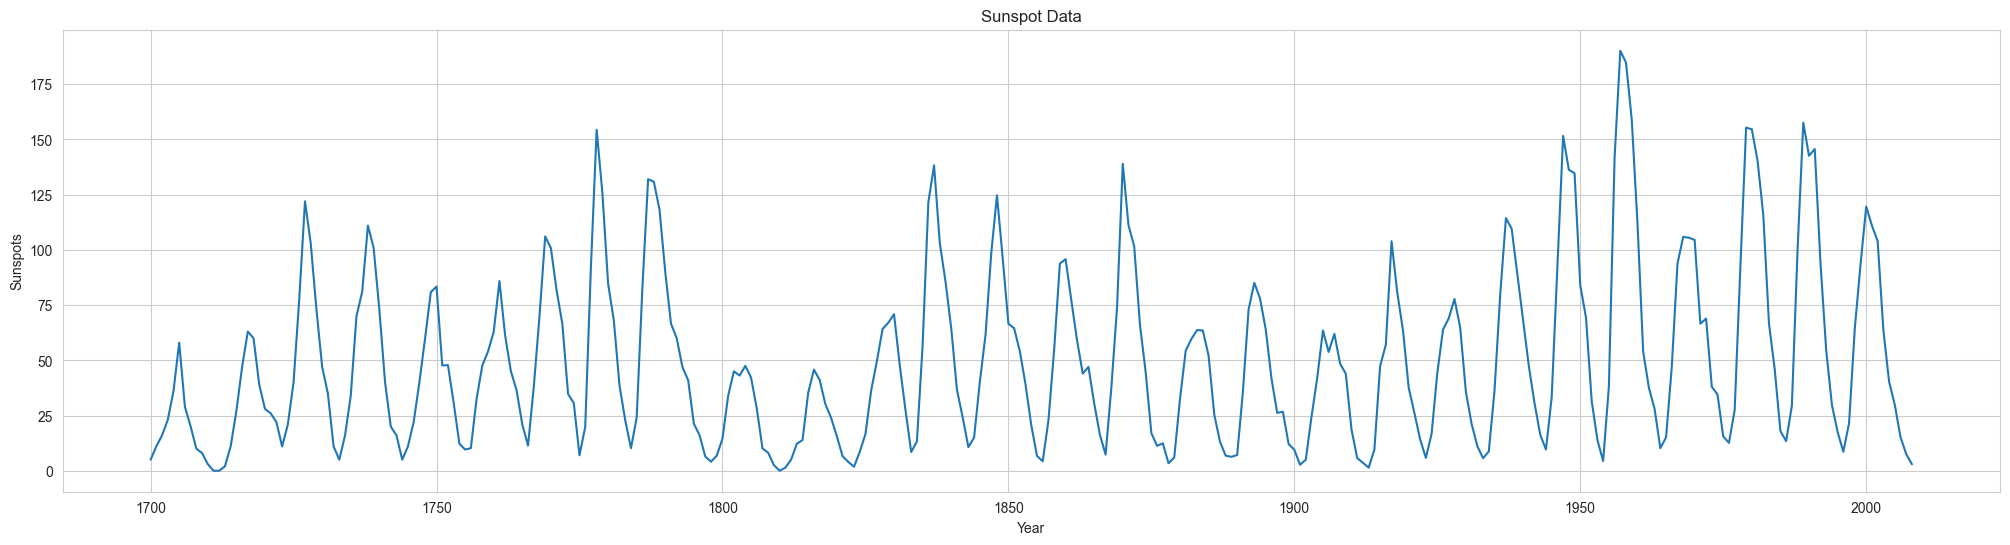

In [30]:
plt.figure(figsize=(25, 6))
plt.plot(ts)
plt.title('Sunspot Data')
plt.xlabel('Year')
plt.ylabel('Sunspots')
plt.show()

# ADF Analysis

## is stationary?




In [31]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

test_stationarity(ts)

ADF Statistic: -2.837781
p-value: 0.053076
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


We observe that the ADF statistic, which is $-2.837781$, is greater than the critical value for the $ 5\% $ level, but less than the critical value for the $ 10\% $ level. This means that we can reject the null hypothesis of a unit root (non-stationarity) at the $ 10\% $ level, but not at the $ 5\% $ level.

The p-value is $0.053076$, which is just above the typical significance level of $0.05$. This means that the evidence against the null hypothesis is not strong enough at the $ 5\% $ level, and we fail to reject the null hypothesis that the time series is non-stationary.

Thus the time series is non-stationary.

# ACF & PACF


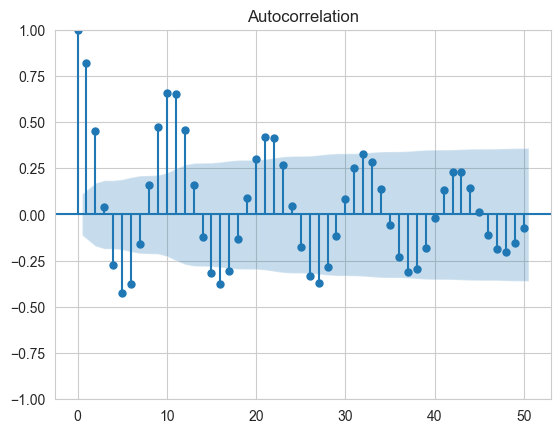

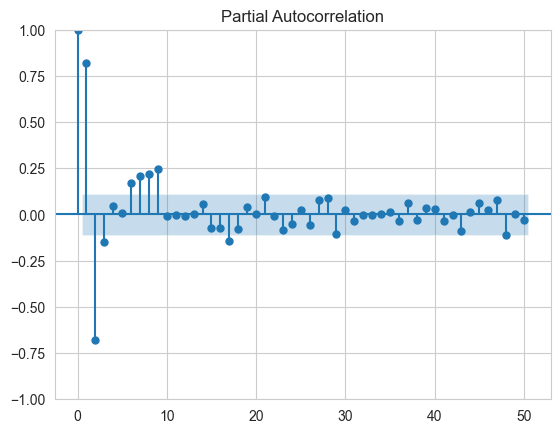

In [32]:
plot_acf(ts, lags=50)
plot_pacf(ts, lags=50)
plt.show()

### Observations
- The `ACF` plot shows a slow decay, which is a sign of non-stationarity.
- The `PACF` plot shows a sharp cutoff after lag $1$, which is a sign of stationarity.

# STL Analysis

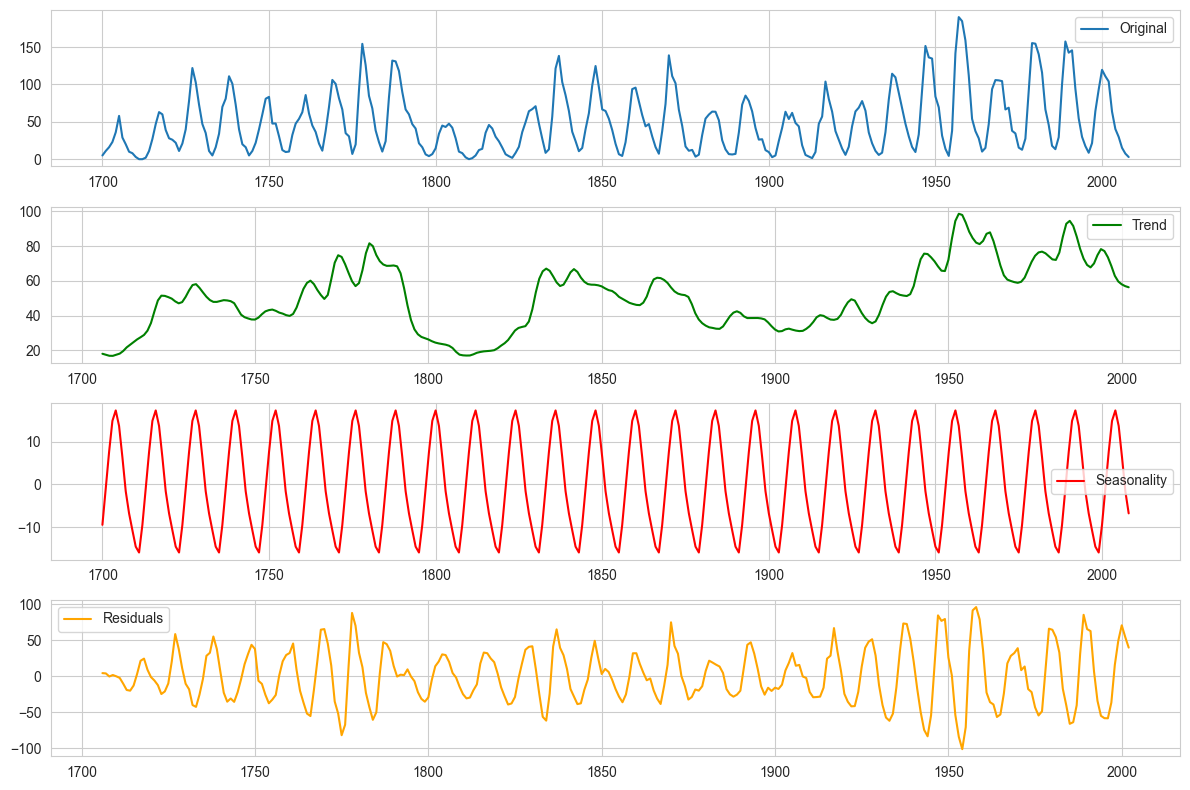

In [33]:
decomposition = seasonal_decompose(ts, model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="orange")
plt.legend(loc='best')
plt.tight_layout()

### Observations

- **Trend** component does not show a simple linear increase or decrease but exhibits multiple turning points, suggesting a more complex, non-linear long-term behavior in the sun activity levels.

- **Seasonal** component shows clearly a seasonal pattern. We can see that there is a consistent amplitude and frequency of the seasonal pattern. This can be related to the solar cycle, which is known to influence sunspot activity.

- **Residuals** display variability that the trend and seasonal components do not capture. They are not completely random, indicating the potential presence of additional patterns or cyclic behavior. The residuals do not center around zero consistently, showing periods of higher and lower than expected values, which may suggest volatility clustering or the influence of external factors not accounted for by the seasonal or trend components.

---
In order to use an ARIMA model, we need to make the time series stationary, as the ADF test showed that it is non-stationary. We will use the `diff()` function to difference the time series and make it stationary.

In [34]:
ts_diff = (ts - ts.shift(1)).dropna()
test_stationarity(ts_diff)

ADF Statistic: -14.861663
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


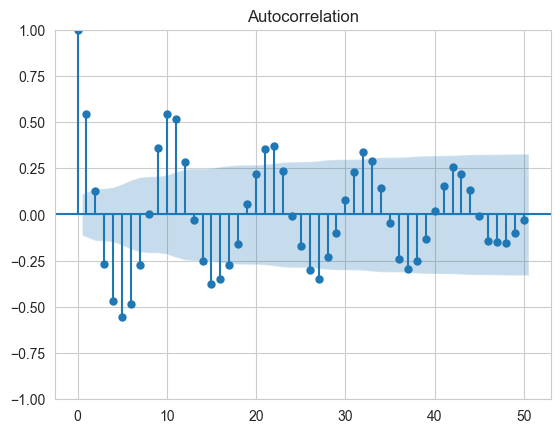

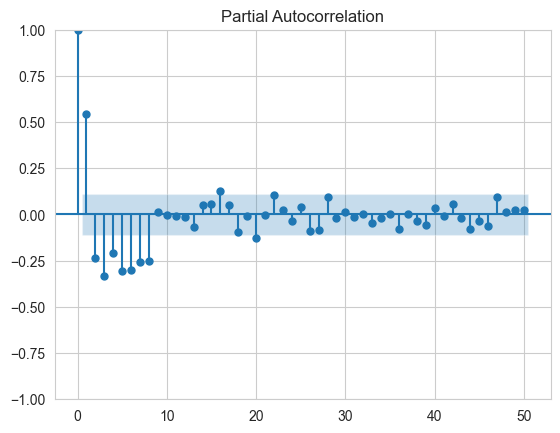

In [35]:
plot_acf(ts_diff, lags=50)
plot_pacf(ts_diff, lags=50)
plt.show()

# ARIMA Model
### p= 9, because the PACF plot shows a sharp cutoff after lag 9, which suggests that there are 9 lags that are significantly different from zero.
### q= 1, because the ACF plot shows a sharp cutoff after lag 1, which suggests that there is one lag that is significantly different from zero.
### d= 1, because we differenced the time series once to make it stationary.

In [36]:
train, test = ts[:int(len(ts)*0.8)], ts[int(len(ts)*0.8):]

arima = ARIMA(train, order=(9, 1, 1))
arima_fit = arima.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test, arima_forecast)
arima_summary = arima_fit.summary()

print(arima_summary)
print('ARIMA MSE:', arima_mse)

c:\Users\billi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            SUNACTIVITY   No. Observations:                  247
Model:                 ARIMA(9, 1, 1)   Log Likelihood                -998.118
Date:                Thu, 11 Apr 2024   AIC                           2018.236
Time:                        20:25:40   BIC                           2056.794
Sample:                             0   HQIC                          2033.762
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7744      0.511      1.514      0.130      -0.228       1.777
ar.L2         -0.3798      0.141     -2.689      0.007      -0.657      -0.103
ar.L3         -0.2260      0.130     -1.740      0.0

c:\Users\billi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# LSTM Model

In [37]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [38]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [40]:
time_steps = 12
X_train, y_train = create_dataset(train_scaled, train_scaled, time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled, time_steps)


In [41]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

c:\Users\billi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


---

# Simple RNN

In [42]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(units=1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

rnn_forecast = rnn_model.predict(X_test)
rnn_forecast = scaler.inverse_transform(rnn_forecast)

c:\Users\billi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


# Plot Actual and Predicted values from all models

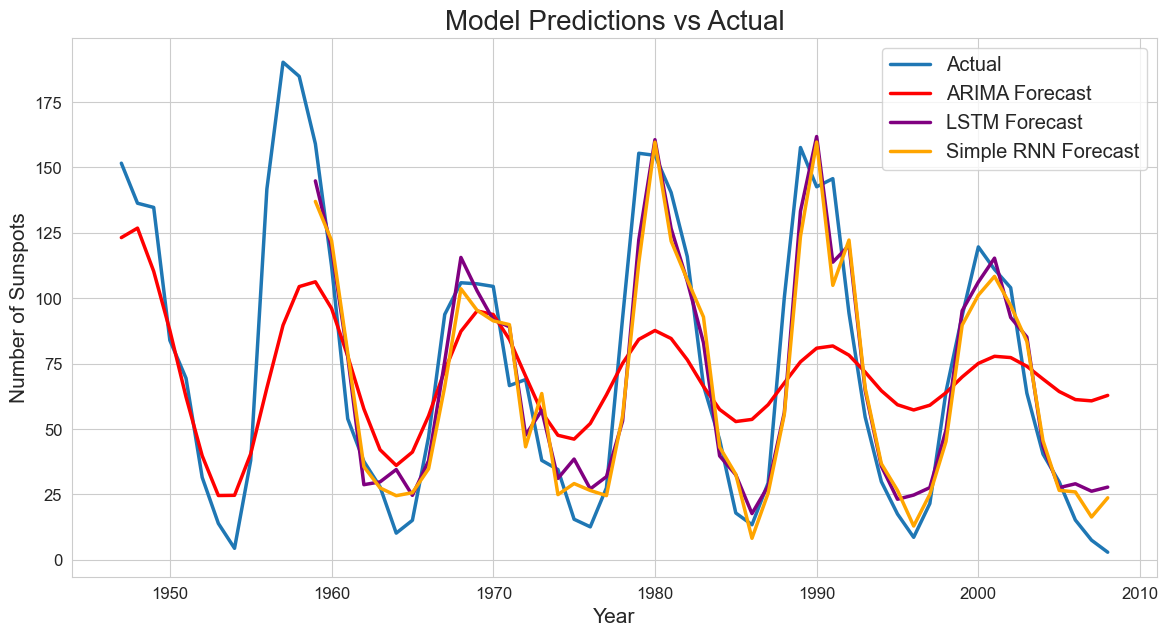

In [43]:
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))

plt.plot(test, label='Actual', linewidth=2.5)
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red', linewidth=2.5)
plt.plot(test.index[time_steps:], lstm_forecast, label='LSTM Forecast', color='purple', linewidth=2.5)
plt.plot(test.index[time_steps:], rnn_forecast, label='Simple RNN Forecast', color='orange', linewidth=2.5)

plt.legend(fontsize='x-large')
plt.title('Model Predictions vs Actual', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Sunspots', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Observations from Plot

1. **Trend Following**: All three models appear to follow the overall cyclical trend of the actual sunspot numbers, which suggests a periodicity characteristic of sunspot activity.

2. **Forecast Accuracy**: 
   - The **ARIMA Forecast** (in red) seems to closely follow the actual data but with a noticeable phase shift; it's lagging slightly behind the actual values.
   - The **LSTM Forecast** (in purple) is closely aligned with the actual data as well, with a bit less of a phase shift than the ARIMA model.
   - The **Simple RNN Forecast** (in orange) is also tracking the trend but appears to have higher variance and sometimes overshoots or undershoots the actual data points more than the other models.

3. **Model Performance**:
   - None of the models perfectly predicts the sunspot numbers, which is expected in such complex natural phenomena.
   - The LSTM model seems to perform the best among the three as it has the highest overlap with the actual data line.

4. **Data Variability**: The number of sunspots shows significant variability over time, with a roughly 10-12 year cycle of rising and falling activity, which all models are attempting to predict.

5. **Outliers**: There are instances where all models fail to predict sudden changes or peaks accurately, indicative of the complex nature of solar activity and the limitations of predictive modeling.

6. **Ending Trends**: Towards the end of the observed period, the models and actual data diverge significantly, especially after 2000, where the models did not predict the actual decline in sunspot numbers.

7. **Forecast Horizon**: It is not clear from the plot whether the forecasts are generated in a rolling manner (updated with new data as it becomes available) or if they were forecasted in one stretch from a start point.


# Plot Performance metric for each method

In [44]:
arima_mse = mean_squared_error(test, arima_forecast)
print('ARIMA Mean Squared Error:', arima_mse)

lstm_mse = mean_squared_error(test[time_steps:], lstm_forecast)
print('LSTM Mean Squared Error:', lstm_mse)

rnn_mse = mean_squared_error(test[time_steps:], rnn_forecast)
print('Simple RNN Mean Squared Error:', rnn_mse)

ARIMA Mean Squared Error: 1485.7467188862493
LSTM Mean Squared Error: 301.4427555313584
Simple RNN Mean Squared Error: 352.2355358886496


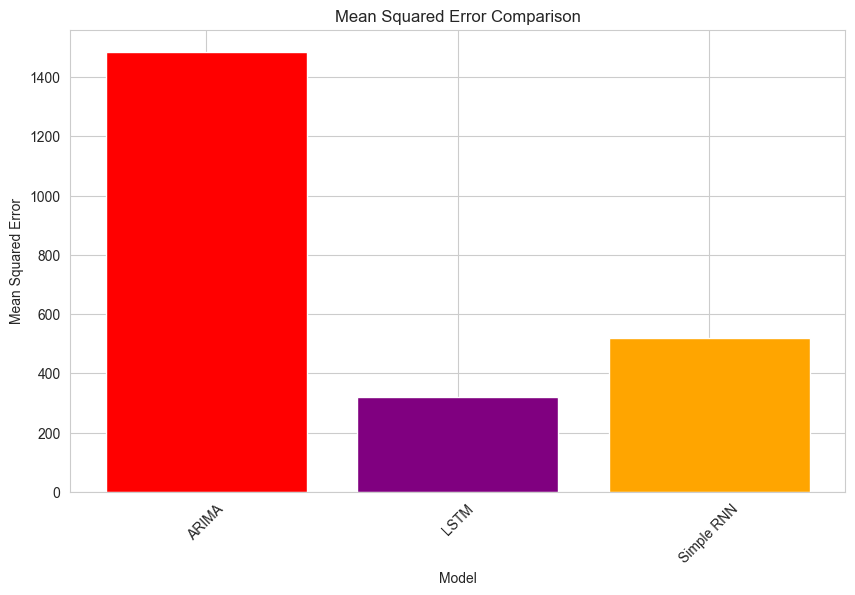

In [23]:
models = ['ARIMA', 'LSTM', 'Simple RNN']
mse_values = [arima_mse, lstm_mse, rnn_mse]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['red', 'purple', 'orange', 'green'])
plt.title('Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()

### Observations from the MSE Comparison Plot

1. **ARIMA Model Performance**: The ARIMA model has the highest MSE, suggesting it is the least accurate in predicting sunspot numbers compared to the other two models.

2. **LSTM Model Performance**: The LSTM model has a significantly lower MSE than ARIMA, indicating it has a much better fit to the actual data.

3. **Simple RNN Performance**: The Simple RNN has a higher MSE than LSTM but lower than ARIMA, placing it in the middle in terms of predictive accuracy.

4. **Overall Comparison**: The ranking in terms of performance, from best to worst based on this error metric, is LSTM, Simple RNN, and then ARIMA.
